In [21]:
from pathlib import Path
import numpy as np
import hicstraw
import seaborn as sns
import matplotlib.pyplot as plt

In [22]:
nm = 1
m = 1e9 * nm
um = 1e3 * nm
s = 1
ns = 1e-9 * s
us = 1e-6 * s
ms = 1e-3 * s

uM = 6.02 * 10 ** 17 / m ** 3
M = 1e6 * uM 
kDa = 1

# Setup

In [23]:
hic_path = Path("/Users/ishangaur/ep-analysis/GSM4873116_WT-HUDEP2-captureHiC_allValidPairs.hic")
hic = hicstraw.HiCFile(str(hic_path))
print("Number of chromosome objects:", len(hic.getChromosomes()))
print("Genome ID:", hic.getGenomeID())
res = hic.getResolutions()
print("Available resolutions:", np.asarray(res) / 1000, "kb")

Number of chromosome objects: 26
Genome ID: /secondary/projects/zhang/tools/Hic-Pro/HiC-Pro_2.8.0/annotation/chrom_hg19.sizes
Available resolutions: [2500. 1000.  500.  250.  100.   50.   25.   10.    5.] kb


So want to request 5299 and 5304 kb on the rows to get the HS2 enhancer and do the full range (5270 to 5303) plus mb a two similar length pieces on either side

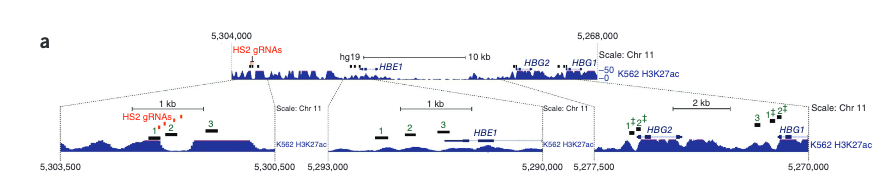
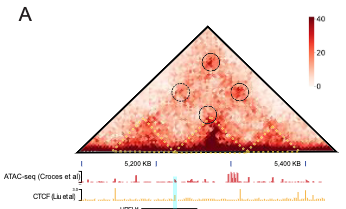

In [24]:
HS2_loc = (5300000, 5303000)
HBE1_loc = (5290000, 5293000)
HBG1_loc = (5270000, 5273000)
HBG2_loc = (5274000, 5276000)

HBG_TAG_loc = (5225000, 5349000)

In [25]:
mzd = hic.getMatrixZoomData("11", "11", "observed", "KR", "BP", hic.getResolutions()[-1])
probs = mzd.getRecordsAsMatrix(HS2_loc[0], HS2_loc[1], HBG_TAG_loc[0], HBG_TAG_loc[1])
probs = probs / probs.sum()
print(probs.shape)
print(probs)
probs = probs[0]

(1, 25)
[[0.02144649 0.01250274 0.01176873 0.02265363 0.03043035 0.02658108
  0.01635145 0.01783358 0.01602282 0.0116351  0.02028131 0.02650136
  0.02757081 0.0383168  0.19656818 0.09022713 0.20995567 0.07028622
  0.03774652 0.03543269 0.02248637 0.01550706 0.00851119 0.00904221
  0.00434052]]


What's up with the little U in the max probability at indices (0-indexed) 14 to 16?

"0.20420567 0.09373283 0.21811332"

These are also the max!

In [26]:
np.argmax(probs)

16

In [27]:
def geneIndexIn(geneLoc, TAGLoc, res):
    return int((geneLoc[0] - TAGLoc[0]) / res), int((geneLoc[1] - TAGLoc[0]) / res)

Where do each of our points of interest fall in this chart?

In [28]:
print(geneIndexIn(HS2_loc, HBG_TAG_loc, res[-1]))
print(geneIndexIn(HBE1_loc, HBG_TAG_loc, res[-1]))
print(geneIndexIn(HBG1_loc, HBG_TAG_loc, res[-1]))
print(geneIndexIn(HBG2_loc, HBG_TAG_loc, res[-1]))

(15, 15)
(13, 13)
(9, 9)
(9, 10)


<Axes: >

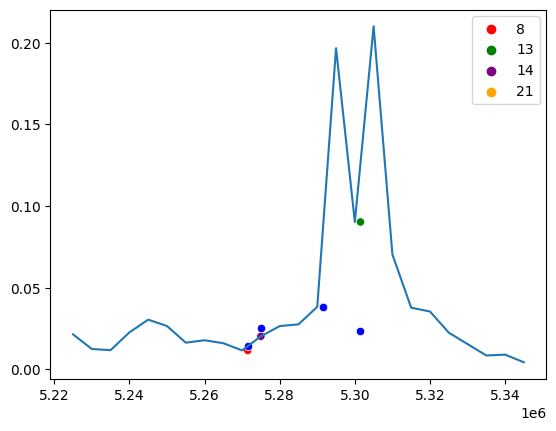

In [41]:
from statistics import mean
HS2, HBE1, HBG1, HBG2 = 15, 13, 9, 10
HS2_ac, HBE1_ac, HBG1_ac, HBG2_ac = 13, 21, 8, 14 # note the HBG1 and 2 are taking into account the duplicate amplicons
ac_levels = np.asarray([HS2_ac, HBE1_ac, HBG1_ac, HBG2_ac])
locs = [HS2_loc, HBE1_loc, HBG1_loc, HBG2_loc]
indices = [HS2, HBE1, HBG1, HBG2]
pos = {HS2: 0, HBE1: 1, HBG1: 2, HBG2: 3}
colors = ['red', 'green', 'purple', 'orange']

sns.lineplot(x=np.arange(HBG_TAG_loc[0], HBG_TAG_loc[1], res[-1]), y=probs)
sns.scatterplot(x=[mean(loc) for loc in locs], y=[probs[i] for i in indices], hue=ac_levels, palette=colors)
# sns.scatterplot(x=[mean(loc) for loc in locs], y=ac_levels / ac_levels[pos[HS2]] * probs[HS2], color="black")
sns.scatterplot(x=[mean(loc) for loc in locs], y=ac_levels / ac_levels[pos[HBE1]] * probs[HBE1], color="blue")

# Simulating as a Boltzmann Distribution

<Axes: >

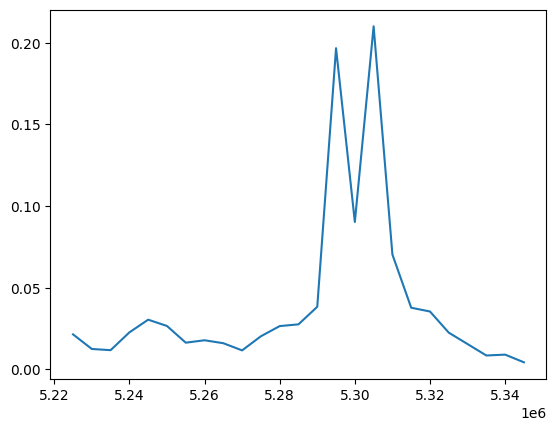

In [30]:
sns.lineplot(x=np.arange(HBG_TAG_loc[0], HBG_TAG_loc[1], res[-1]), y=probs)

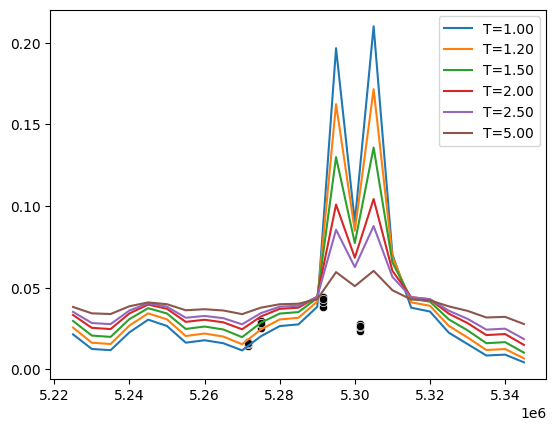

In [45]:
E = -np.log(probs)
for T in [1, 1.2, 1.5, 2, 2.5, 5]:
    prob_T = np.exp(-E / T)
    prob_T = prob_T / prob_T.sum()
    sns.lineplot(x=np.arange(HBG_TAG_loc[0], HBG_TAG_loc[1], res[-1]), y=prob_T, label=f"T={T:.2f}")
    sns.scatterplot(x=[mean(loc) for loc in locs], y=ac_levels / ac_levels[pos[HBE1]] * prob_T[HBE1], color="black")

# Diffusion Simulation

In [32]:
side_n = 101
voxel_len = 5 * nm
voxel_size = voxel_len ** 3
dt = 1 * us

In [33]:
diam_to_vol = lambda d: 4 / 3 * np.pi * (d / 2) ** 3
nucleus_diam = 5 * um
nuclear_volume = diam_to_vol(nucleus_diam)
open_dna_percent = 1 / 9 # approximately from https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3202292/#:~:text=The%20number%20of%20combined%20significant,Methods)%20for%20each%20cell%20line.
volume = open_dna_percent * nuclear_volume # assuming things basically just bouce off of closed DNA and due to binding/unbinding spend more time near the open DNA

In [34]:
tf_num_nucleus = 1500
tf_diam = 5 * nm # min needed to be gene specific based on simulations https://iopscience.iop.org/article/10.1088/0953-8984/27/6/064116; mass 50kDa
tf_mass = 50 * kDa
tf_vol = diam_to_vol(tf_diam)
C_tf = tf_num_nucleus * tf_vol / nuclear_volume # fraction of space in the volume take up by TFs
D = 2.5 * um ** 2 / s # diffusion coefficient, based on derda2 in https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5602325/
promoter_frequency = 1 / (30 * s) # switching frequency from Zuin et al. 2022
print("Fraction of nuclear volume taken up by TFs:", C_tf)
print("Diffusion coefficient:", D / (um ** 2) * s, "um^2/s")

Fraction of nuclear volume taken up by TFs: 1.5e-06
Diffusion coefficient: 2.5 um^2/s


In [35]:
def p300_specs(lambda_ac, p300_range, verbose=False):
    # nuclear_acetyl_coa = 3 * uM # in cancer cells, Sivanand 2018

    # p300 model gives a uniform chance of acetylation in a given volume
    # Km for p300 AT domain was calculated to be 9.8 µM: https://www.ncbi.nlm.nih.gov/pmc/articles/PMC60180/
    # mass is 300 kDa
    p300_mass = 300 * kDa
    scaling_factor = np.power(p300_mass / tf_mass, 1/3)
    p300_act_vol = diam_to_vol(p300_range * 2 + tf_diam * scaling_factor) - diam_to_vol(tf_diam * scaling_factor) # volume of binding domain around p300 as it moves
    num_tf = tf_num_nucleus * p300_act_vol / volume # number of tfs in p300's range of action
    # tf_ac_production = num_tf * (1 - np.exp(-dt/lambda_ac)) # num_tf * P(acetylation in interval dt) = tf / dt --> becomes a bad approximatino for large dt as the prob saturates
    tf_ac_production = num_tf / lambda_ac * dt
    # tf_ac_production = 0
    if verbose:
        print("Range of action:", p300_act_vol / (nm ** 3), "nm^3")
        print("Num TFs in range of action:", num_tf)
    return tf_ac_production

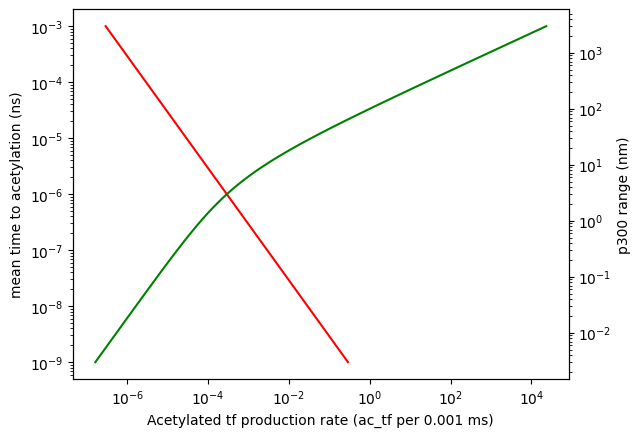

In [36]:
lambda_ac = 1 * us # mean time to an acetylation for tf in range of p300; total guess!!!
p300_range = 3 * nm # range of p300: guesstimate from large cross-linker spans
p300_specs(lambda_ac, p300_range)

multiples = np.logspace(-3, 3, 100)
outputs_ac = [p300_specs(lambda_ac * m, p300_range) for m in multiples]
outputs_range = [p300_specs(lambda_ac, p300_range * m) for m in multiples]

# changing P(acetylation)
x_ac = multiples * lambda_ac
sns.lineplot(x=outputs_ac, y=x_ac, color="r")
plt.xlabel(f"Acetylated tf production rate (ac_tf per {dt / ms} ms)")
plt.xscale('log')
plt.yscale('log')
plt.ylabel("mean time to acetylation (ns)")

# changing p300 range
ax2 = plt.twinx()
x_range = multiples * p300_range
sns.lineplot(x=outputs_range, y=x_range, ax=ax2, color="g")
ax2.set_ylabel("p300 range (nm)")
ax2.set_yscale('log')


The range of 10s of acetylated transcription factors produced per second seems plausible if there is to be a solid gradient of tfs in the presence of continuous deacetylation. We will continue with lambda_ac = 10 us, range = 3 nm.
Recall that promoter bursting times are on the order of minutes as well. This also places us on the part of the range modulation curve which might make sense for a promiscuous binder.

In [37]:
ac_tf_production = p300_specs(1 * us, 3 * nm, verbose=True)
print("Acetylated transcription factor production rate is approximately", ac_tf_production / dt / ns * s, " per second")
print("Acetylated transcription factor production rate is approximately", ac_tf_production, " per dt")

Range of action: 1404.8743580769171 nm^3
Num TFs in range of action: 0.0002897761372702492
Acetylated transcription factor production rate is approximately 289776137270.24915  per second
Acetylated transcription factor production rate is approximately 0.0002897761372702492  per dt


In [38]:
num_HDAC = 1500 * 5 # mid-range of tf counts and times 5 because there are so many kinds of HDACs maybe a couple will be effective
lambda_dac = 10 * ns # prob of acetylation: ac_tf / ms * tf
HDAC_mass = 60 * kDa # https://www.ptglab.com/products/HDAC1-Antibody-10197-1-AP.htm#:~:text=The%20molecular%20size%20of%20HDAC1%20is%2060%20kDa. for HDAC1
HDAC_range = 1 * nm # range of crosslinkers I've heard of for tight interactions
scaling_factor = np.power(HDAC_mass / tf_mass, 1/3)
HDAC_act_vol = diam_to_vol(HDAC_range * 2 + tf_diam * scaling_factor) - diam_to_vol(tf_diam * scaling_factor) # volume of binding domain around HDAC as it moves
P_HDAC = num_HDAC * HDAC_act_vol / volume
# P_deacetylation_per_step = P_HDAC * (1 - np.exp(-dt / lambda_dac)) # dac / dt * tf exponential distribution for each time step
P_deacetylation = P_HDAC / lambda_dac
# P_deacetylation = 0
print(f"Num HDACs and fraction of nuclear volume taken up by HDACs:", num_HDAC, P_HDAC / num_HDAC)
print(f"HDAC volume of action and rate of dac per tf * {dt / ns:0.2f} ns timestep", HDAC_act_vol / (nm ** 3), "nm^3")
print(f"HDAC deacetylation rate within p300 range of action:", P_deacetylation * ac_tf_production * dt, "ac_tf/dt")

Num HDACs and fraction of nuclear volume taken up by HDACs: 7500 1.736251195316701e-08
HDAC volume of action and rate of dac per tf * 1000.00 ns timestep 126.26374999984826 nm^3
HDAC deacetylation rate within p300 range of action: 3.77343123532295e-06 ac_tf/dt


From this is seems like HDACs have such lower capture probability that it doesn't make sense that they would be limiting the distribution by pervasively stopping it. Instead it could make total sense if they were addregated around the DNA in the TAD, around the boundaries of the condensates, preventing any of them from getting out while acetylated.

In [39]:
world = np.zeros((2 + side_n, 2 + side_n, 2 + side_n))
# world[1 + side_n // 2, 1 + side_n // 2, 1 + side_n // 2] = 0
time = 0

In [40]:
run_size = 100000
voxel_fraction = (voxel_len ** 3) / volume
# P_deacetylation_per_step = 0
P_deacetylation_per_step = P_deacetylation * dt
# plt.clf()
# sns.heatmap(world[1:-1, 1:-1, 1 + side_n // 2])
# plt.show()
for i in range(run_size):
    # plt.clf()
    dx = (world[:-1, 1:-1, 1:-1] - world[1:, 1:-1, 1:-1]) / voxel_len
    # sns.heatmap(dx[:, :, 5])
    # plt.show()
    # plt.clf()
    dx2 = (dx[:-1, :, :] - dx[1:, :, :]) / voxel_len
    # sns.heatmap(dx2[:, :, 5])
    # plt.show()
    dy = (world[1:-1, :-1, 1:-1] - world[1:-1, 1:, 1:-1]) / voxel_len
    dy2 = (dy[:, :-1, :] - dy[:, 1:, :]) / voxel_len
    dz = (world[1:-1, 1:-1, :-1] - world[1:-1, 1:-1, 1:]) / voxel_len
    dz2 = (dz[:, :, :-1] - dz[:, :, 1:]) / voxel_len
    # plt.clf()
    dC = D * dt * (dx2 + dy2 + dz2)
    # sns.heatmap(dC[:, :, 5])
    # plt.show()
    world[1:-1, 1:-1, 1:-1] += dC
    world[1 + side_n // 2, 1 + side_n // 2, 1 + side_n // 2] += ac_tf_production
    world[1:-1, 1:-1, 1:-1] *= (1 - P_deacetylation_per_step)
    # plt.clf()
    # sns.heatmap(world[1:-1, 1:-1, 1 + side_n // 2])
    # plt.show()
time += dt * run_size
sns.heatmap(world[1:-1, 1:-1, 1 + side_n // 2])
plt.title(f"t={time/ms:0.2f} ms, #TF={tf_num_nucleus}, #HDAC={num_HDAC}, D={D / um ** 2 * s:0.2f} um^2/s, P_deac={P_deacetylation:0.2f}, P_ac={1 / lambda_ac / s:0.2f}")

KeyboardInterrupt: 